# Let's try to code up non-spinning TaylorT1

Reference: http://arxiv.org/abs/0907.0700 and http://arxiv.org/abs/0709.0093

In [9]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [10]:
import phenom

In [11]:
def Energy(v, eta):
    # 2PN
    return -0.5 * eta * v**2 * (
        1 - (0.75 + eta/12) * v**2 - (27/8 - 19/8*eta + eta**2/24)*v**4
    )

In [12]:
def Flux(v, eta):
    # 2PN
    return 32/5 * eta**2 * v**10 * (
        1 - (1247/336 + 35/12*eta)*v**2 + 4*np.pi*v**3 - (44711/9072 - 9271/504*eta - 65/18*eta**2)*v**4
    )

In [13]:
def dEdv(v, eta):
    # 2PN
    return -eta*v*(
        1 + (-3/2 - eta/6)*v**2 + (-81/8 + 57*eta/8 - eta**2/8)*v**4
    )

Quasi-circular orbits

Energy Balance for to get equations of motion.

$$
F(v) = -\frac{dE(v)}{dt}
$$

We can rearrange to get a differential equation for the evolution of v(t).

$$
F(v) = -\frac{dE(v)}{dv} \frac{dv}{dt}
$$

$$
\frac{dv}{dt} = -\frac{F(v)}{dE(v)/dv }
$$

Additionally we can relate the orbital velocity $v(t)$ to the orbital phase with

$$
\frac{d\phi(t)}{dt} = v^3(t)
$$

So once we have $v(t)$ from energy balance we can use this as the source term and integrate $v^3(t)$ in time to get the binary orbital phase.

In [14]:
def rhs(t, y, eta):
    v = y[0]
    numerator = Flux(v, eta)
    denominator = dEdv(v, eta)
    return -numerator/denominator

In [15]:
# initial conditions
# initial GW frequency F_0
# initial velocity v0 = (pi*F_0)**(1/3)

In [16]:
# chirp time or coalescence time
# Gravitational-Wave Physics and Astronomy: Creighton
# equation 3.178d
def chirp_time(eta, F0, M=1):
    """
    F0: initial GW frequency in dimensionless units
    """
    return 5/256/eta * M * (np.pi*M*F0)**(-8/3)

In [17]:
phenom.HztoMf(10, 1)

4.92549102554e-05

In [18]:
chirp_time(0.25, 4.92549102554e-05)

1132030906.9784846

In [19]:
phenom.MtoS(1132030906, 1)

5575.808068136916

In [20]:
%%time

# you must set t_span to a large enough value so that the binary evolution
# 'fits inside' the time array.
# for inspirals that have a low initial frequency this can be very very large.

##
f_orb_start_Mf = 0.001
omega_orb_start_Mf = 2*np.pi*f_orb_start_Mf

f_gw_start_Mf = 2*f_orb_start_Mf 
M = 1 # the code currently only works with M = 1
f_gw_start_Hz = phenom.MftoHz(f_gw_start_Mf, M)

eta = 0.25
time_until_merger = chirp_time(eta, f_gw_start_Mf)


##


v0 = omega_orb_start_Mf**(1/3)

t_span = [0, int(time_until_merger)]


# t_span = [-10000, 100]
# t_span = [0, 1000]
y0 = [v0]
# t_eval = np.arange(t_span[0], t_span[1], 0.1)
# sol = solve_ivp(rhs, t_span, y0, args=[mu], t_eval=t_eval)
sol = solve_ivp(rhs, t_span, y0, args=[eta], rtol=1e-10, atol=1e-10, dense_output=True, method='DOP853')

CPU times: user 14.2 ms, sys: 3.89 ms, total: 18.1 ms
Wall time: 15.8 ms


In [21]:
t_span

[0, 58117]

In [22]:
sol.t.shape

(93,)

In [23]:
v0

0.18452701486440287

In [24]:
sol.y[0][-1]

0.515588368322005

In [25]:
sol.y[0][0]

0.18452701486440287

Text(0.5, 1.0, 'orbital velocity vs time (M)')

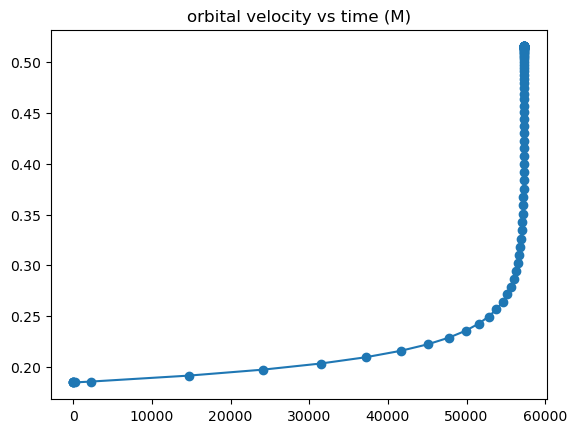

In [26]:
plt.figure()
plt.plot(sol.t, sol.y[0], '-o')
plt.title("orbital velocity vs time (M)")

Text(0.5, 1.0, 'orbital angular frequency vs time (M)')

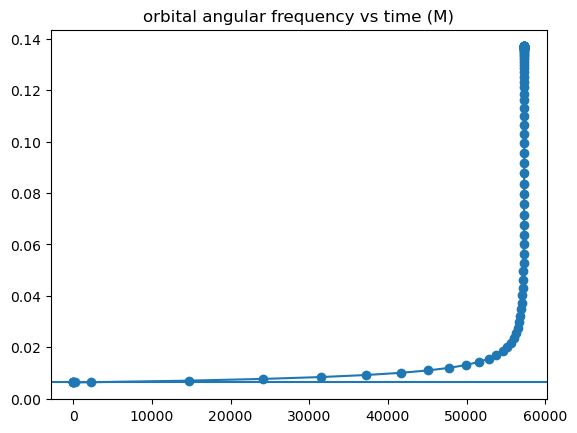

In [27]:
plt.figure()
plt.plot(sol.t, sol.y[0]**3, '-o')
plt.axhline(omega_orb_start_Mf)
plt.title("orbital angular frequency vs time (M)")
# plt.xscale('log')
# plt.yscale('log')

Text(0.5, 1.0, 'orbital velocity vs orbital angular frequency')

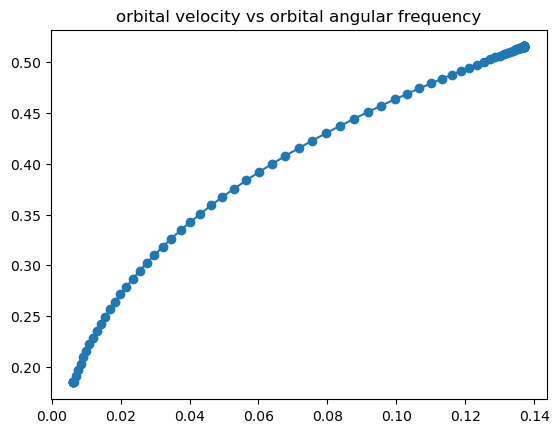

In [32]:
plt.figure()
plt.plot(sol.y[0]**3, sol.y[0], '-o')
# plt.axhline(omega_orb_start_Mf)
plt.title("orbital velocity vs orbital angular frequency")
# plt.xscale('log')
# plt.yscale('log')

# refactor

In [65]:
def TaylorT1_orbital_frequency(eta, Omega_orb_start, t_len_factor=2):
    """
    eta: symmetric mass ratio
    Omega_orb_start: orbital angular frequency in dimensionless units at start
    """
    # estimate signal duration
    f_gw = Omega_orb_start/2/np.pi * 2
    t_len = chirp_time(eta, f_gw)
    # saftely factor to account for inaccuracies in chirp_time
    t_len *= t_len_factor

    # inital orbital velocity
    v0 = Omega_orb_start**(1/3)
    
    t_span = [0, int(t_len)]
    y0 = [v0]
    sol = solve_ivp(rhs, t_span, y0, args=[eta], rtol=1e-10, atol=1e-10, dense_output=True, method='DOP853')

    return sol

In [53]:
phenom.eta_from_q(2)

0.2222222222222222

In [70]:
qs = [1,2,3,4]
sols=[]
for q in qs:
    sols.append(TaylorT1_orbital_frequency(phenom.eta_from_q(q), 0.01))

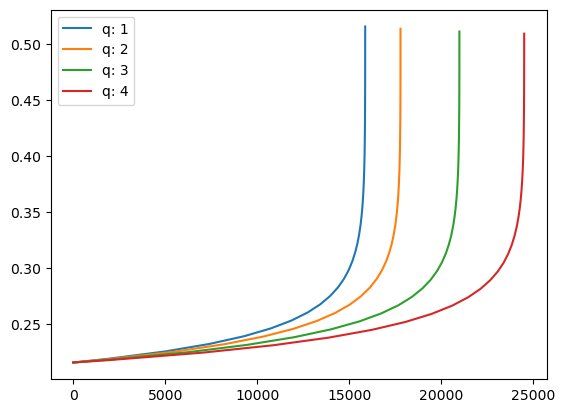

In [71]:
for i in range(len(qs)):
    plt.plot(sols[i].t, sols[i].y[0], label=f"q: {qs[i]}")
plt.legend()

# compare with LAL?

In [73]:
import lalsimulation as lalsim

In [75]:
import pycbc.waveform

lal.MSUN_SI != Msun
setting __package__ to gwsurrogate.new so relative imports work
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new
setting __package__ to gwsurrogate.new so relative imports work
setting __package__ to gwsurrogate.new so relative imports work


In [91]:
0.01 / 2 / np.pi * 2

0.003183098861837907

In [92]:
phenom.MftoHz(0.00318309, 1)

646.2482590050047

In [103]:
hp, hc = pycbc.waveform.get_td_waveform(approximant="TaylorT1", mass1=0.5, mass2=0.5, f_lower=646, delta_t=1/2048/2/2)

In [104]:
freq = pycbc.waveform.utils.frequency_from_polarizations(hp, hc)

In [105]:
plt.plot(freq.sample_times, freq)

In [106]:
lal_times = np.array(freq.sample_times)
lal_freq = np.array(freq)

lal_times_M = phenom.StoM(lal_times, 1)
lal_freq_M = phenom.HztoMf(lal_freq, 1)

In [107]:
lal_times_M[0]

-16171.155035505839

In [108]:
lal_times_M[-1]

-12.39170870142888

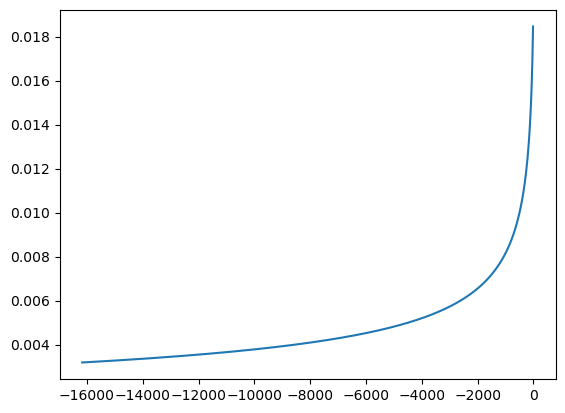

In [109]:
plt.plot(lal_times_M, lal_freq_M)

In [110]:
sol = TaylorT1_orbital_frequency(0.25, 0.01)

In [116]:
plt.plot(lal_times_M-lal_times_M[-1], lal_freq_M, label='LAL')
plt.plot(sol.t-sol.t[-1], sol.y[0]**3/2/np.pi*2, label='Mine')
plt.legend()
plt.title("22 GW angular frequency vs time (M)")

Text(0.5, 1.0, '22 GW angular frequency vs time (M)')